**Micrograd**

**Creating Tanh based Neuron and Backpropogation using vanila python**

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        #rmul is basically mul but allows 2*a = a*2
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
  
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
   
        def _backward():
            # o = tanh(n)
            # do/dn = 1 - o**2
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
    
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

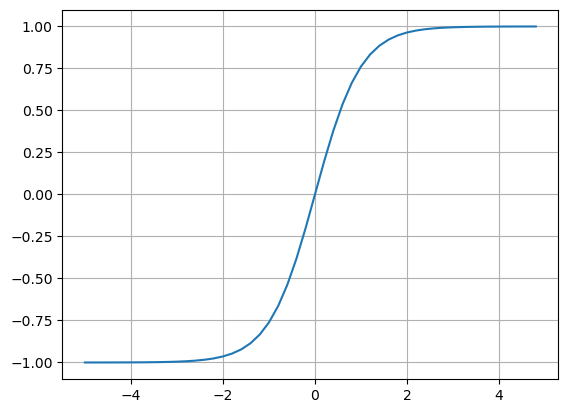

In [3]:
#tanh activation function
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [4]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [5]:
#back propogation
o.backward()

In [6]:
b.grad

0.4999999999999999

**Doing the same but with PyTorch**

In [7]:
import torch
import random

In [8]:
#Tensors are arrays
#casting to double to have float64 precision. Default is float.
x1 = torch.Tensor([2.0]).double()       ; x1.requires_grad = True  #forcing requirement of gradient for leaf nodes
x2 = torch.Tensor([0.0]).double()       ; x2.requires_grad = True 
w1 = torch.Tensor([-3.0]).double()      ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()       ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()     ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())  #.item() strips the tesnor and returns the scalar value
o.backward()
print("---")
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
---
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [9]:
class Neuron:
    #nin = number of inputs
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    #Ex of call
    #x = [2.0, 3.0]
    #n = Neuron(2)
    #n(x)
    def __call__(self, x):
        # w * x + b -> single neuron
        # zip creates element wise tuples of two arrays
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) #self.b is starting point for summation
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)] #layer is a list of neurons
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for Layer in self.layers:
            x = Layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [10]:
#Example
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.877502359781211)

**Example Dataset**

In [11]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
] #attributes
ys = [1.0, -1.0, -1.0, 1.0] #targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.877502359781211),
 Value(data=-0.12446686310838183),
 Value(data=-0.9327429785406832),
 Value(data=-0.7836826220596104)]

In [12]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
#need to minimize the loss
loss

Value(data=7.477620587952318)

In [13]:
loss.backward()

In [14]:
n.layers[0].neurons[0].w[0].grad

0.1384423378879714

In [15]:
#this means that increasing weight[0] will decrease the loss

In [16]:
n.layers[0].neurons[0].w[0].data

-0.16061061269803756

In [17]:
for p in n.parameters():
    p.data += -0.01 * p.grad
    #so if grad is negative for a weight, we want to increase that weight so as to minimize the loss
    #-0.01 is the "learning rate" here
    #you might miss local minima is learning rate is too high, but it might take too long if the learning rate is high

In [18]:
n.layers[0].neurons[0].w[0].grad

0.1384423378879714

In [19]:
for k in range(20):#of epochs
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    #backward pass
    for p in n.parameters():
        p.grad = 0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 6.942919287250653
1 3.2903818536603895
2 1.3666559545905284
3 0.6492004142082208
4 0.4224047218700334
5 0.30683701732852087
6 0.2364294265268797
7 0.18999785723848114
8 0.15755026438477776
9 0.13382224216980418
10 0.11583427186849782
11 0.10179571722336338
12 0.09057522569818555
13 0.0814274155201934
14 0.07384352478426932
15 0.06746567469446366
16 0.06203551149436218
17 0.0573622850007421
18 0.05330235813252049
19 0.04974567627023259


In [20]:
ypred

[Value(data=0.9261772727220776),
 Value(data=-0.8519104579901724),
 Value(data=-0.9424604393428183),
 Value(data=0.8619617164907499)]